# 1. Setup

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.vision import *
from pathlib import Path

# 2. Dataset

## 2.1 Mount Drive and Setup Paths

In [0]:
!wget -O unet_dataset.zip https://files.slack.com/files-pri/TJRDXSH3L-FL91UDJFR/download/unet_dataset.zip?pub_secret=4ec1f235fb

--2019-07-08 07:36:22--  https://files.slack.com/files-pri/TJRDXSH3L-FL91UDJFR/download/unet_dataset.zip?pub_secret=4ec1f235fb
Resolving files.slack.com (files.slack.com)... 13.32.84.205
Connecting to files.slack.com (files.slack.com)|13.32.84.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134746555 (129M) [application/zip]
Saving to: ‘unet_dataset.zip’

unet_dataset.zip    100%[===================>] 128.50M  25.2MB/s    in 5.9s    

2019-07-08 07:36:28 (21.8 MB/s) - ‘unet_dataset.zip’ saved [134746555/134746555]



In [0]:
!unzip -qq unet_dataset.zip 

In [0]:
path = Path('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train')

In [0]:
path.ls()

[PosixPath('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/SegmentationClassPNG'),
 PosixPath('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/valid.txt'),
 PosixPath('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/SegmentationClassVisualization'),
 PosixPath('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/class_names.txt'),
 PosixPath('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages'),
 PosixPath('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/SegmentationClass')]

In [0]:
path_img = path/'JPEGImages'
path_lbl = path/'SegmentationClassPNG'
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

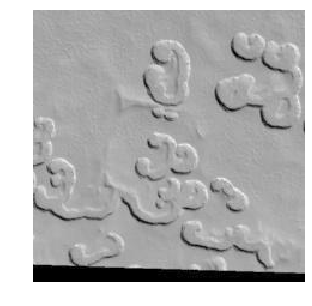

In [0]:
img_f = fnames[900]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [0]:
get_y_fn = lambda x : path_lbl/f'{x.stem}.png'
get_y_fn(img_f)

PosixPath('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/SegmentationClassPNG/ESP_012810_0925_RED-0030-brt.png')

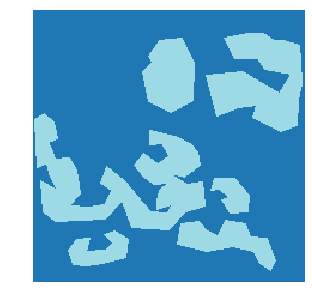

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [0]:
with open(path/'class_names.txt') as f:
  codes = np.array([line.strip() for line in f.readlines()])
codes

array(['_background_', 'Crater', 'Dark Dune', 'Slope Streak', 'Bright Dune', 'Impact Ejecta', 'Swiss Cheese', 'Spider'],
      dtype='<U13')

In [0]:
import matplotlib.image as mpimg
mpimg.imread(str(path/'JPEGImages/ESP_011289_1950_RED-0009-brt.jpg')).shape

(227, 227)

In [0]:
mask.shape

torch.Size([1, 227, 227])

In [0]:
src_size = np.array(mask.shape[1:])
size = 224 # src_size # src_size // 2
bs = 8

In [0]:
size, bs

(224, 8)

## 2.2 Initialize Validation Set (You can skip this step since I have saved the generated validation set in the zipped folder)

In [0]:
import random

In [0]:
def traverse_files(root_dir, img_names):
  global count
  for dir in os.listdir(root_dir):
    if not os.path.isfile(root_dir/dir):
      traverse_files(root_dir/dir)
    else:
      if dir.endswith('.jpg'):
        img_names.append(dir)

In [0]:
validation_image_names = []
for i in range(1, 8):
  img_names = []
  traverse_files(Path(f'drive/My Drive/Mars-Omdena/Aman_Folder/{i}/train'), img_names)
  validation_image_names.extend(random.choices(img_names, k=45))

In [0]:
len(validation_image_names)

315

In [0]:
with open(path/'valid.txt', 'w') as f:
    for item in validation_image_names:
        f.write("%s\n" % item)

## 2.3 Initialize DataBunch

In [0]:
import PIL

In [0]:
path_lbl_npy = path/'SegmentationClass'

In [0]:
dir_name = Path('SegmentationLabels')
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
    
def get_segmentation_label_fn(img_f):  
  label_imgname = dir_name/f'{img_f.stem}.png'
  if os.path.exists(label_imgname):
    return label_imgname
  
  npy_filename = path_lbl_npy/f'{img_f.stem}.npy'
  img = PIL.Image.fromarray(np.load(npy_filename))  
  img.save(label_imgname)
  return label_imgname

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_segmentation_label_fn, classes=codes)
      )

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats)
       )

CPU times: user 2.85 s, sys: 1.52 s, total: 4.38 s
Wall time: 4.6 s


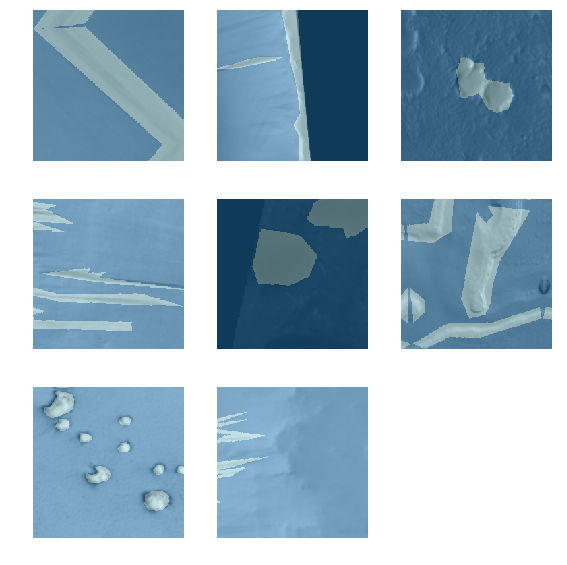

In [0]:
%%time
data.show_batch(rows=3, figsize=(8, 8))

In [0]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['_background_']
void_code

0

# 3. Model

In [0]:
def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [0]:
learn = unet_learner(data, models.resnet18, metrics=acc_camvid, wd=1e-2)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


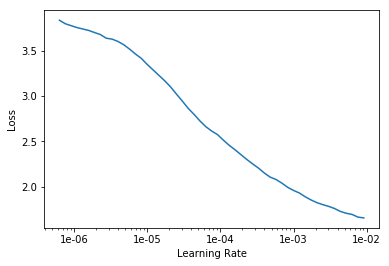

In [0]:
learn.recorder.plot()

In [0]:
lr = 3e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.592589,0.509814,0.295602,01:02
1,0.518910,0.512763,0.163675,01:00
2,0.479906,0.453552,0.177416,00:59
3,0.466019,0.471399,0.282068,00:59
4,0.461205,0.373071,0.461679,00:58
5,0.427193,0.387443,0.417710,00:58
6,0.430693,0.401643,0.381786,00:57
7,0.393114,0.423764,0.491900,00:57
8,0.400363,0.328689,0.524605,00:57
9,0.300757,0.261782,0.606307,00:57


In [0]:
learn.save('mars-unet-1')

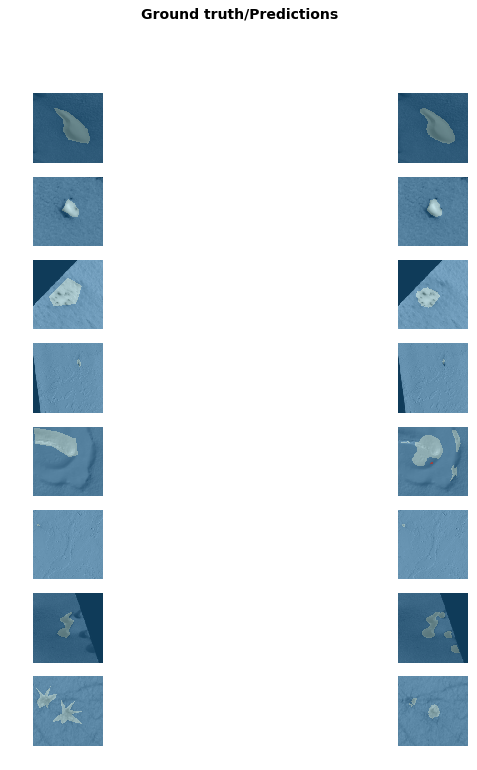

In [0]:
learn.show_results(rows=10, figsize=(12, 12)) # show results

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,acc_camvid,time
0,0.258488,0.257734,0.656202,00:59
1,0.261847,0.254262,0.651071,01:00
2,0.245725,0.253907,0.660071,00:59
3,0.225729,0.241487,0.677490,01:00
4,0.244400,0.244900,0.723507,01:00
5,0.228173,0.228456,0.684190,01:00
6,0.225772,0.238199,0.655789,01:00
7,0.227144,0.229613,0.643996,00:59
8,0.237136,0.219988,0.700605,01:00
9,0.214956,0.211767,0.752074,01:00


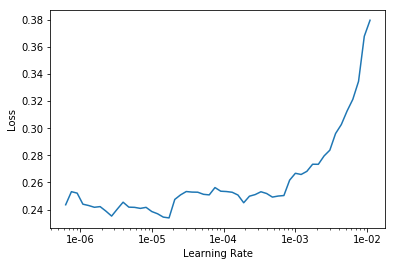

In [0]:
learn.unfreeze() # unfreeze all layers

# find and plot lr again
learn.lr_find()
learn.recorder.plot()

# train model 
learn.fit_one_cycle(12, slice(lr/400, lr/4), pct_start=0.8)

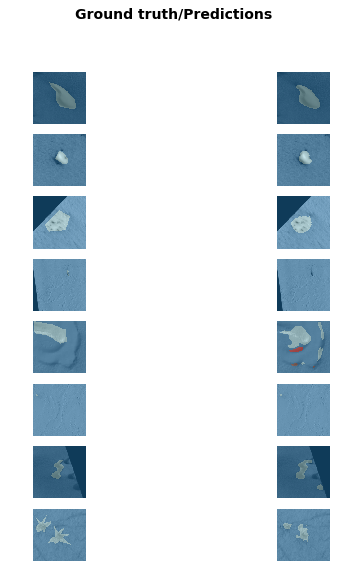

In [0]:
learn.show_results(rows=20, figsize=(8, 9)) # show results

In [0]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
__________________________________________________

# 4. Predictions

In [0]:
learn.pred_batch(data.one_item).shape

torch.Size([8, 8, 224, 224])

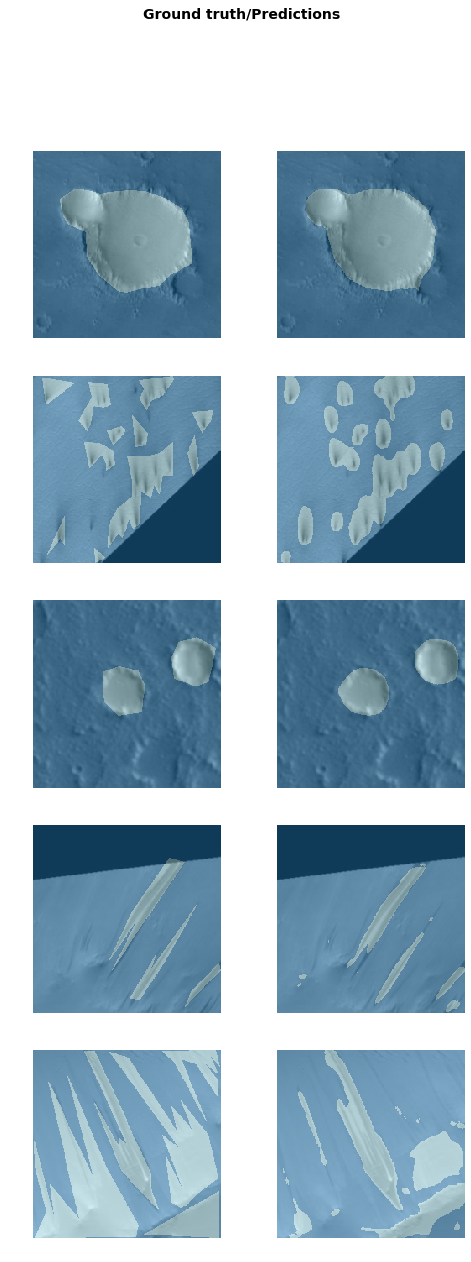

In [0]:
learn.show_results(data.one_item)